In [16]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

In [18]:
# impot data
eps = 1
N = 2500

num_bins_list = np.linspace(10 ** 5, 10 ** 6, 10, dtype=int)

success_list = []
coins_list = []
errors_list = []
label_list = []

with open(f'results/continuum/noisy_binary_search/N_{N}/eps_{eps}/success.pkl', 'rb') as f:
    success = pickle.load(f)
with open(f'results/continuum/noisy_binary_search/N_{N}/eps_{eps}/coins.pkl', 'rb') as f:
    coins = pickle.load(f)
with open(f'results/continuum/noisy_binary_search/N_{N}/eps_{eps}/errors.pkl', 'rb') as f:
    errors = pickle.load(f)
    
success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append('NaiveNBS')

with open(f'results/continuum/BayeSS/N_{N}/eps_{eps}/success.pkl', 'rb') as f:
    success = pickle.load(f)
with open(f'results/continuum/BayeSS/N_{N}/eps_{eps}/coins.pkl', 'rb') as f:
    coins = pickle.load(f)
with open(f'results/continuum/BayeSS/N_{N}/eps_{eps}/errors.pkl', 'rb') as f:
    errors = pickle.load(f)

success_list.append(success)
coins_list.append(coins)
errors_list.append(errors)
label_list.append('BayeSS')

def upload_data(N: int):
    folder_name = f"data/continuum/N_{N}"
    output = {}
    # import data
    with open(f'{folder_name}/pareto_data.pkl', 'rb') as f:
        data = pickle.load(f)
    output["data"] = data

    # import median
    with open(f'{folder_name}/pareto_median.pkl', 'rb') as f:
        median = pickle.load(f)
    output["median"] = median

    # import median quantile
    with open(f'{folder_name}/pareto_median_quantile.pkl', 'rb') as f:
        median_quantile = pickle.load(f)
    output["median_quantile"] = median_quantile

    # import cdf
    with open(f'{folder_name}/pareto_cdf.pkl', 'rb') as f:
        cf_dict = pickle.load(f)
    output["cf_dict"] = cf_dict

    return output


data = upload_data(N)

In [19]:
colors = ['b', 'g']
markers = ["--", "-"]

# Success probability vs number of bins

In [28]:
def get_binomial_std(p, n):
    return np.sqrt(p * (1 - p) / n)

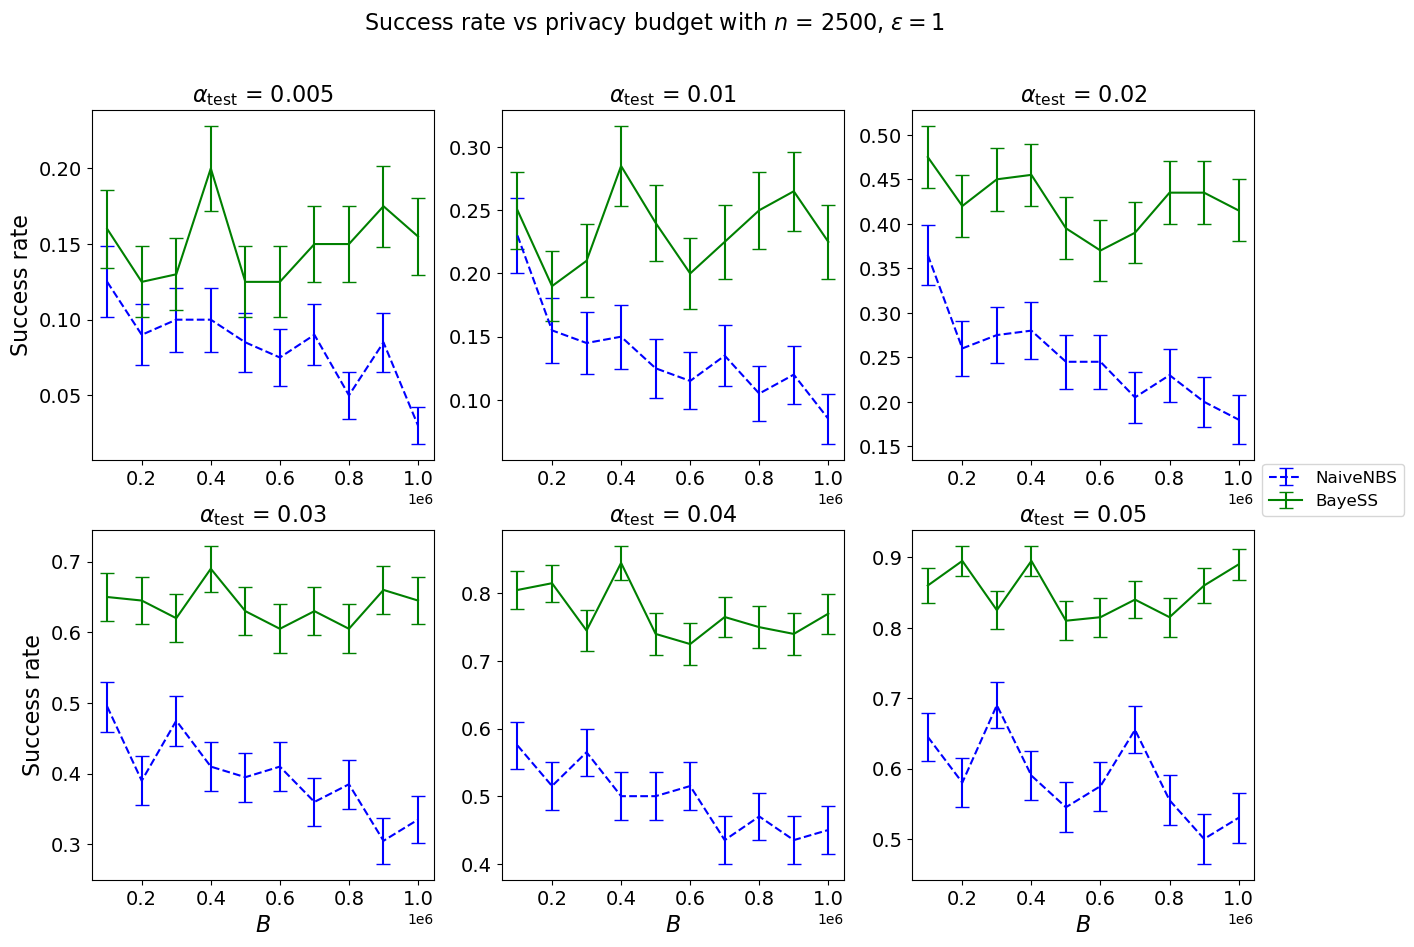

In [39]:
import tqdm as tq

def get_success(coin, cf_dict, alpha, target):
    coin = int(coin)
    cf_dict_domain = np.array(list(cf_dict.keys()))
    # if coin not in cf_dict.keys():
    #     for index in reversed(range(coin)):
    #         if index in cf_dict.keys():
    #             coin = index
    #             break
    # find the coin with the closest value
    cf_dict_coin = cf_dict_domain[np.argmin(np.abs(cf_dict_domain - coin))]
    if cf_dict_coin > coin:
        # get index of the coin
        index = np.where(cf_dict_domain == cf_dict_coin)[0][0]
        coin = cf_dict_domain[index - 1]
    else:
        coin = cf_dict_coin
    if target - alpha < cf_dict[coin] < target + alpha:
        success = True
    else:
        success = False
    return int(success)


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
alpha_test_list = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

for fig_index, alpha_test in enumerate(alpha_test_list):
    ax = axs[fig_index // 3, fig_index % 3]  # Access subplot correctly
    for i, coins in enumerate(coins_list):
        success = np.zeros((len(num_bins_list), len(coins[0])))
        for j in range(len(num_bins_list)):
            for c, coin in enumerate(coins[j]):
                success[j, c] = get_success(coin, data["cf_dict"], alpha_test, 0.5)
        ax.errorbar(num_bins_list,
                    np.mean(success, axis=1),
                    yerr=get_binomial_std(np.mean(success, axis=1), success.shape[1]),
                    fmt=markers[i],
                    label=label_list[i],
                    color=colors[i],
                    capsize=5)
    if fig_index // 3 == 1:
        ax.set_xlabel(r"$B$", fontsize=16)
    if fig_index % 3 == 0:
        ax.set_ylabel("Success rate", fontsize=16)
    ax.set_title(r"$\alpha_{\text{test}}$ = " + str(alpha_test), fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14) 

# make unique legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)
fig.suptitle(fr"Success rate vs privacy budget with $n$ = {N}, $\varepsilon = {eps}$", fontsize=16)

# save figure
folder_name = "final"
if not os.path.exists(f"figures/{folder_name}"):
    os.makedirs(f"figures/{folder_name}")
plt.savefig(f"figures/{folder_name}/success_rate_vs_B_N_{N}_eps_{eps}.png", bbox_inches='tight')

plt.show()